In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.impute import SimpleImputer, SamplingImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def make_train_test_missings(X_train, X_test, n_missing, column, missing_in_test):
    missings_train = np.random.choice(np.arange(X_train.shape[0]), int(X_train.shape[0]*n_missing), replace=False)
    missings_test = np.random.choice(np.arange(X_test.shape[0]), int(X_test.shape[0]*n_missing), replace=False)
    
    X_train[missings_train, column] = np.nan
    
    if missing_in_test:
        X_test[missings_test, column] = np.nan
  
    return X_train, X_test

In [3]:
x_min, x_max = -1, 5
y_min, y_max = -1, 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))
xx = xx.flatten().reshape(-1,1)
yy = yy.flatten().reshape(-1,1)
G = np.hstack((xx, yy))

In [4]:
def plot_predict_proba(ax, clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    good_mask = y_pred == y_test
    Z = clf.predict_proba(G)
    Z *= 0.8
    Z += 0.2
    Z *= 0.8
    
    ax.scatter(G[:,0], G[:,1], c=Z, cmap=plt.cm.cool, alpha=.7, marker='s')
    ax.scatter(X_test[good_mask,0], X_test[good_mask,1], c=y_pred[good_mask], cmap=plt.cm.cool, edgecolors='k', marker='o')
    ax.scatter(X_test[~good_mask,0], X_test[~good_mask,1], c=y_pred[~good_mask], cmap=plt.cm.cool, edgecolors='k', marker='*')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    #ax.set_aspect('equal')

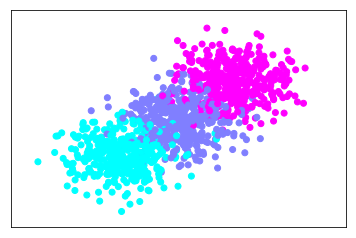

In [5]:
# make dataset
X, y = make_blobs(centers=[[1,1], [2,2], [3,3]], n_features=2, n_samples=1200, cluster_std=0.5)

fig, ax = plt.subplots(1,1)
ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.cool)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

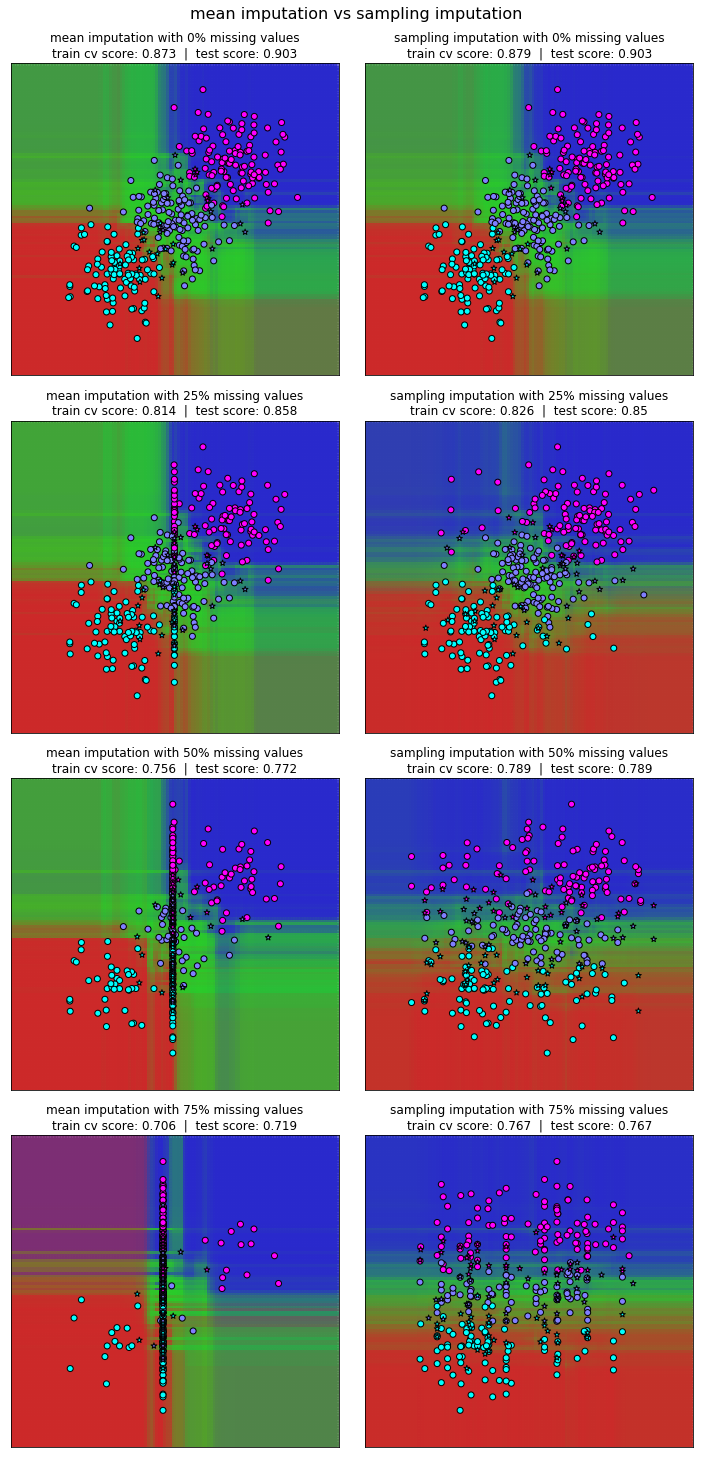

In [6]:
test_size = 0.3
rf_mean_n_estimators = 1000
rf_sampl_n_estimators = 10
bagging_n_estimators = 100
list_n_missing = [0.0, 0.25, 0.5, 0.75]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

fig, ax = plt.subplots(len(list_n_missing), 2)

for i, n_missing in enumerate(list_n_missing):
    X_train, X_test = make_train_test_missings(X_train, X_test, n_missing, 0, True)
    
    # mean
    imputer = SimpleImputer()
    rf = RandomForestClassifier(n_estimators=rf_mean_n_estimators)
    clf = Pipeline([('imputer', imputer), ('rf', rf)])

    clf.fit(X_train, y_train)
    X_test_imputed = clf.steps[0][1].transform(X_test)
    cv_score = np.around(cross_val_score(clf, X_train, y_train, cv=10).mean(), 3)
    test_score = np.around(clf.score(X_test, y_test), 3)

    plot_predict_proba(ax[i,0], clf, X_test_imputed, y_test)
    s = 'mean imputation with ' + str(int(n_missing*100)) + '% missing values\n'\
        + 'train cv score: ' + str(cv_score) + '  |  test score: ' + str(test_score)
    ax[i,0].set_title(s)
    
    
    # sampling
    imputer = SamplingImputer()
    rf = RandomForestClassifier(n_estimators=rf_sampl_n_estimators)
    pipeline = Pipeline([('imputer', imputer), ('rf', rf)])
    clf = BaggingClassifier(base_estimator=pipeline, n_estimators=bagging_n_estimators)

    clf.fit(X_train, y_train)
    X_test_imputed = clf.estimators_[0].steps[0][1].transform(X_test)
    cv_score = np.around(cross_val_score(clf, X_train, y_train, cv=10).mean(), 3)
    test_score = np.around(clf.score(X_test, y_test), 3)
    
    plot_predict_proba(ax[i,1], clf, X_test_imputed, y_test)
    s = 'sampling imputation with ' + str(int(n_missing*100)) + '% missing values\n'\
        + 'train cv score: ' + str(cv_score) + '  |  test score: ' + str(test_score)
    ax[i,1].set_title(s)
  

fig.set_size_inches(10, 20)
fig.suptitle('mean imputation vs sampling imputation', y=1.01, fontsize=16)
fig.tight_layout()
plt.show()

background: predict proba. 
 - toward red -> class 1
 - toward green -> class 2
 - toward blue -> class 3

points: X_test after imputation. Color = predicted class
 - Circles -> class predicted well
 - stars -> class predicted wrong